In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import pandas as pd
import scipy.linalg as la

import seaborn as sn
import matplotlib.font_manager as fm

In [196]:
font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

base = {
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.bottom": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
}

sn.set_theme(context='notebook', style=base, palette='rocket_r', color_codes=True, rc=None)

In [190]:
# --- physical constants --- #

hbar = 0.658 # ev fs
m0 = 5.6856800 # fs{2} eV nm{-2}
veps0 = 5.52638e-2 # c{2} eV{-1} nm{-1}
n = 1.82
c0 = 299.792 # nm/fs
kb = 8.617e-5 # ev K {-1}

# --- system parameters --- #

Lwell = 0.636 # nm
A = Lwell**2 # nm{2}
Gamma0 = 0.0067 # eV
Msigma = 8 # fs ev nm{-1}
DAC = 1.9 # eV
DOP = 158 # ev nm{-1}
EgZero = 2.565 # eV

alphaOne = -1e-4 # material specific constant for Varshni shift
alphaTwo = 340 # material specific constant for Varshni shift

# --- simulation parameters --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

In [182]:
# --- import eigenvalues and eigenvectors calculated by solving the Wannier equation --- #

eigenvalues = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvalues5.txt')
eigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvectors5.txt')

polarEigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/EigenvectorsSlashed5.txt')

In [183]:
def BandGap(temperature):
    return EgZero - (alphaOne*temperature**2)/(alphaTwo+temperature)

def FFT(mu, eigenvectors): # inverse fourier transform of the amplitude of the wavefunctions

    C = A * dk / (2*np.pi)
    integral = np.sum(eigenvectors[mu][-500:] * k_vals)

    return (C * integral)**2

def RadiativeRecom(mu, eigenvalues, eigenvectors): # Temperature independent radiactive recombination of eletrons

    wavefunction = FFT(mu, eigenvectors)
    C = (hbar * Msigma**2) / (2 * m0**2 * veps0 * n * c0)

    return C * wavefunction / eigenvalues[mu]

def ExcitonDephase(mu, temp): # Phenomenological non-radiative dephasing term

    return RadiativeRecom(mu, eigenvalues, eigenvectors) + (0.0067 / (np.exp(0.037/(kb*temp))-1))

In [184]:
def Absorption(energy_range, eigenvalues, eigenvectors, temp):

    alpha = []

    for E in energy_range:
        alphaMu = 0

        for mu in range(len(eigenvalues)):

            E0 = BandGap(temp) - eigenvalues[mu]

            numerator = 2 * RadiativeRecom(mu, eigenvalues, eigenvectors) * ExcitonDephase(mu, temp)
            denominator = (E0 - E)**2 + (ExcitonDephase(mu, temp) + RadiativeRecom(mu, eigenvalues, eigenvectors))**2
            alphaMu += numerator/denominator

        alpha.append(alphaMu)
        
    maxAlpha = max(alpha)

    return alpha


In [185]:
def Absorption2(T):

    sum_sigma = 0
    Energy = np.linspace(2,3,10000)

    dE = ((alphaOne*T**2)/(alphaTwo+T))
    Egt = EgZero-dE
    absorption_sum = 0

    for i in range(0, 5):
        E_0 = Egt - eigenvalues[i]

        phi2=0

        for j in range(500):
            phi2 += polarEigenvectors[i, j]*(A *k_vals[j]*dk/(2*np.pi))

        gamma = hbar/(2*m0**2*veps0*n*c0)*Msigma**2*np.absolute(phi2)**2/eigenvalues[0]
        Gamma = gamma + (0.0067 / (np.exp(0.037/(kb*T))-1))

        absorption_alpha = 2*gamma*Gamma/((E_0-Energy)**2+(Gamma+gamma)**2)
        absorption_sum+=absorption_alpha

    return absorption_sum

In [192]:
def FinalPlot(temps):

    E = np.linspace(2, 3, 10000)
    data = {"Energy": E}
    norm = 0
    
    for T in temps:
        #data[f'{T}'] = Absorption(energy_range=E, eigenvalues=eigenvalues, eigenvectors=eigenvectors, temp=T)
        data[f'{T}'] = Absorption2(T)
        
        maximum = np.max(data[f'{T}'])
        if maximum > norm:
            norm = maximum

    df = pd.DataFrame(data)

    mosaic = """ 
            AA
            BC
            
            """
    fig = plt.figure(layout='constrained', figsize=(8,8))
    ax_dict = fig.subplot_mosaic(mosaic, gridspec_kw={'hspace': 0})

    for column in df.columns[1:]:
        ax_dict["A"].plot((df['Energy'] - eigenvalues[0]), df[column]/norm, label=f'T = {column} K', linewidth=3)
        ax_dict["A"].set_xlim(2.15, 2.45)
        ax_dict["A"].set_title('(a)',  fontsize=16)
        ax_dict["A"].legend(fontsize=16)
        ax_dict["A"].tick_params(labelsize=16)

        ax_dict["B"].plot((df['Energy'] - eigenvalues[0]), df[column]/norm, label=f'T = {column} K', linewidth=3)
        ax_dict["B"].set_xlim(2.2, 2.3)
        ax_dict["B"].set_title('(b)',  fontsize=16)
        ax_dict["B"].tick_params(labelsize=16)

        ax_dict["B"].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
        #ax_dict["B"].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        #ax_dict["B"].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        #ax_dict["B"].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

        ax_dict["C"].plot((df['Energy'] - eigenvalues[0]), df[column]/norm, label=f'T = {column} K', linewidth=3)
        ax_dict["C"].set_xlim(2.35, 2.45)
        ax_dict["C"].set_title('(c)', fontsize=16)
        ax_dict["C"].tick_params(labelsize=16)

        fig.supxlabel("$E - E_{1s}$ (eV)", fontsize=16)
        fig.supylabel("Absorption coefficient (normalised)", fontsize=16)

        plt.savefig('absorption.pdf', dpi=600)


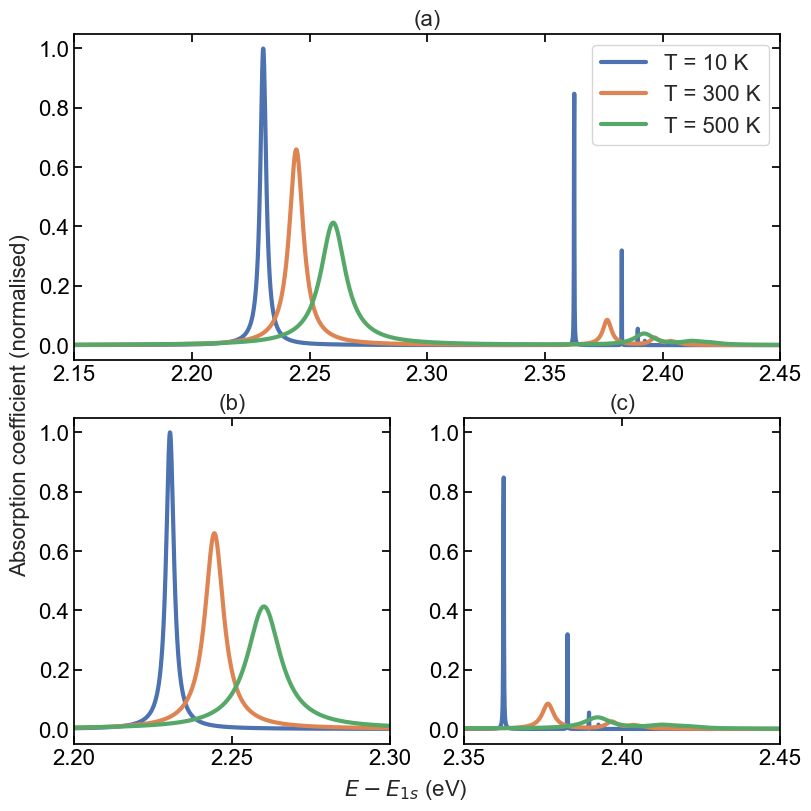

In [193]:
FinalPlot([10, 300, 500])

In [208]:
def PlotLinewidth(eigenvalues, Ti, Tf):

    temps = np.linspace(Ti, Tf, 1000)
    
    Rad0 = []
    NonRad0 = []
    Total0 = []
    Rad1 = []
    NonRad1 = []
    Total1 = []
    Rad2 = []
    NonRad2 = []
    Total2 = []

    for i in [0, 1, 2]:
        for T in temps:

            if i == 0:
                gamma = RadiativeRecom(i, eigenvalues, eigenvectors)
                Gamma = ExcitonDephase(i, T)
                Rad0.append(1000 * gamma)
                NonRad0.append(1000 * Gamma)
                Total0.append(1000*gamma + 1000*Gamma)

            elif i == 1:
                gamma = RadiativeRecom(i, eigenvalues, eigenvectors)
                Gamma = ExcitonDephase(i, T)
                Rad1.append(1000*gamma)
                NonRad1.append(1000*Gamma)
                Total1.append(1000*gamma + 1000*Gamma)

            elif i == 2:
                gamma = RadiativeRecom(i, eigenvalues, eigenvectors)
                Gamma = ExcitonDephase(i, T)
                Rad2.append(1000*gamma)
                NonRad2.append(1000*Gamma)
                Total2.append(1000*gamma + 1000*Gamma)
    
    fig = plt.figure(layout='constrained', figsize=(5, 10))
    gs = fig.subplots(3, 1, sharex=True)
    
    gs[0].set_title('1s - (a)', fontsize=16)
    gs[0].plot(temps, Total0, label='Total', linewidth=3)
    gs[0].plot(temps, NonRad0, label='Phonon', linewidth=3)
    gs[0].plot(temps, Rad0, label='Radiative', linewidth=3)
    
    gs[0].fill_between(temps, Total0, alpha=0.4)
    gs[0].fill_between(temps, NonRad0, alpha=0.4)
    gs[0].fill_between(temps, Rad0, alpha=0.4)
    gs[0].tick_params(labelsize=16)
    gs[0].set_ylim(0, 5)
    gs[0].set_xlim(0, 300)
    
    gs[1].set_title('2s - (b)', fontsize=16)
    gs[1].plot(temps, Total1, label='Total', linewidth=3)
    gs[1].plot(temps, NonRad1, label='Non-radiative', linewidth=3)
    gs[1].plot(temps, Rad1, label='Radiative', linewidth=3)

    gs[1].fill_between(temps, Total1, alpha=0.4)
    gs[1].fill_between(temps, NonRad1, alpha=0.4)
    gs[1].fill_between(temps, Rad1, alpha=0.4)
    gs[1].set_ylabel('Exciton linewidth (meV)', fontsize=16)
    gs[1].tick_params(labelsize=16)
    gs[1].set_xlim(0, 300)
    gs[1].set_ylim(0, 5)
    gs[1].legend(loc='upper left', fontsize=16)

    gs[2].set_title('3s - (c)', fontsize=16)
    gs[2].plot(temps, Total2, label='Total', linewidth=3)
    gs[2].plot(temps, NonRad2, label='Non-radiative', linewidth=3)
    gs[2].plot(temps, Rad2, label='Radiative', linewidth=3)

    gs[2].fill_between(temps, Total2, alpha=0.4)
    gs[2].fill_between(temps, NonRad2, alpha=0.4)
    gs[2].fill_between(temps, Rad2, alpha=0.4)
    gs[2].set_xlabel('Temperature (K)', fontsize=16)
    gs[2].tick_params(labelsize=16)
    gs[2].set_xlim(0, 300)
    gs[2].set_ylim(0, 5)

    plt.savefig('linewidth.pdf', dpi = 600)

/var/folders/4w/q9wgs5k112jdmq5x88r_wyv40000gn/T/ipykernel_4953/2936993775.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  return RadiativeRecom(mu, eigenvalues, eigenvectors) + (0.0067 / (np.exp(0.037/(kb*temp))-1))
/var/folders/4w/q9wgs5k112jdmq5x88r_wyv40000gn/T/ipykernel_4953/2936993775.py:20: RuntimeWarning: overflow encountered in exp
  return RadiativeRecom(mu, eigenvalues, eigenvectors) + (0.0067 / (np.exp(0.037/(kb*temp))-1))


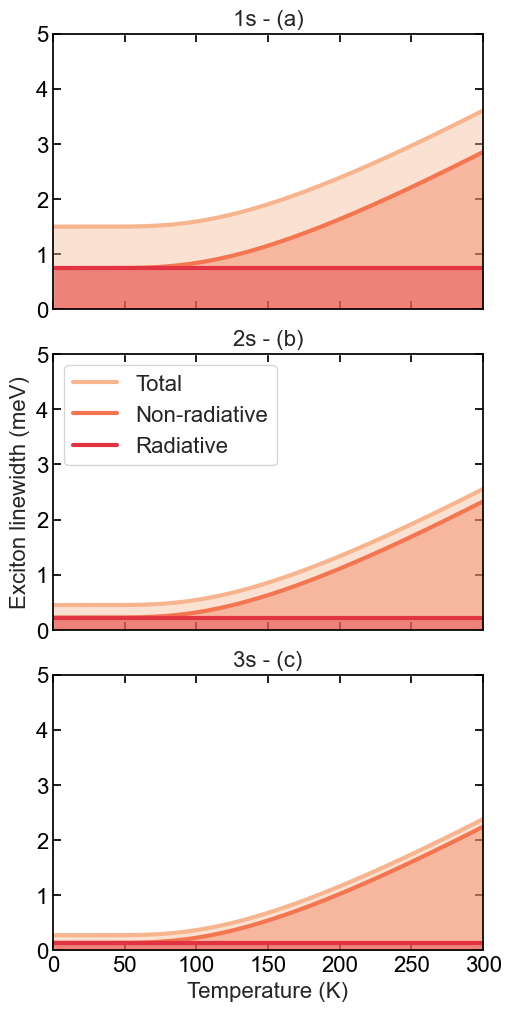

In [209]:
PlotLinewidth(eigenvalues, 0, 300)